In [0]:
import nltk
nltk.download("all")
from nltk import word_tokenize, pos_tag, ne_chunk
from keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import np_utils
import pandas as pd
import re
!pip install konlpy
import konlpy
from konlpy.tag import Okt
from keras.preprocessing.text import Tokenizer
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 토큰화, 품사 태깅

In [4]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [0]:
from nltk import word_tokenize, pos_tag, ne_chunk

In [0]:
sentence = "홍길동이는 오늘 멀티캠퍼스에 지각했습니다"

In [7]:
word_tokenize(sentence)    # 토큰화

['홍길동이는', '오늘', '멀티캠퍼스에', '지각했습니다']

In [8]:
pos_tag(word_tokenize(sentence))    # 토큰화, 품사 태깅

[('홍길동이는', 'JJ'), ('오늘', 'NNP'), ('멀티캠퍼스에', 'NNP'), ('지각했습니다', 'NN')]

In [0]:
sentence2 = "James is working at Samsung in Suwon"

In [14]:
sentence2 = pos_tag(word_tokenize(sentence2))    # 토큰화, 품사 태깅
sentence2

[('James', 'NNP'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('at', 'IN'),
 ('Samsung', 'NNP'),
 ('in', 'IN'),
 ('Suwon', 'NNP')]

In [15]:
ne_chunk(sentence2)    # ne_chunk: 개체 유형 출력 함수

TclError: ignored

Tree('S', [Tree('PERSON', [('James', 'NNP')]), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), Tree('ORGANIZATION', [('Samsung', 'NNP')]), ('in', 'IN'), Tree('GPE', [('Suwon', 'NNP')])])

# LSTM을 이용한 분류 실습

## 데이터 탐색

In [0]:
from keras.datasets import reuters

In [0]:
import numpy as np
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(xtrain, ytrain), (xtest, ytest) = reuters.load_data(num_words=None, test_split=0.2)
# num_words=1000이면 1000등 안에 있는 단어들만 가져오라는 뜻

# restore np.load for future normal usage
np.load = np_load_old

In [64]:
xtrain[0]
# 단어들의 빈도에 따라 인덱스가 부여된 상태
# 1 => 등장 빈도수가 1등
# 27595 => 등장 빈도수가 27595등

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [65]:
len(xtrain)    # 8982 => 8982개의 뉴스 기사가 있다

8982

In [66]:
xtrain[8981]

[1,
 227,
 2406,
 91,
 21969,
 125,
 2855,
 21,
 4,
 3976,
 76,
 7,
 4,
 757,
 481,
 3976,
 790,
 5259,
 5654,
 9,
 111,
 149,
 8,
 7,
 10,
 76,
 223,
 51,
 4,
 417,
 8,
 1047,
 91,
 6917,
 1688,
 340,
 7,
 194,
 9411,
 6,
 1894,
 21,
 127,
 2151,
 2394,
 1456,
 6,
 3034,
 4,
 329,
 433,
 7,
 65,
 87,
 1127,
 10,
 8219,
 1475,
 290,
 9,
 21,
 567,
 16,
 1926,
 24,
 4,
 76,
 209,
 30,
 4033,
 6655,
 5654,
 8,
 4,
 60,
 8,
 4,
 966,
 308,
 40,
 2575,
 129,
 15562,
 295,
 277,
 1071,
 9,
 24,
 286,
 2114,
 234,
 222,
 9,
 4,
 906,
 3994,
 8519,
 114,
 5758,
 1752,
 7,
 4,
 113,
 17,
 12]

In [67]:
xtest[0]

[1,
 4,
 1378,
 2025,
 9,
 697,
 4622,
 111,
 8,
 25,
 109,
 29,
 3650,
 11,
 150,
 244,
 364,
 33,
 30,
 30,
 1398,
 333,
 6,
 18292,
 159,
 9,
 1084,
 363,
 13,
 19231,
 71,
 9,
 16273,
 71,
 117,
 4,
 225,
 78,
 206,
 10,
 9,
 1214,
 8,
 4,
 270,
 5,
 16273,
 7,
 748,
 48,
 9,
 19231,
 7,
 207,
 1451,
 966,
 1864,
 793,
 97,
 133,
 336,
 7,
 4,
 493,
 98,
 273,
 104,
 284,
 25,
 39,
 338,
 22,
 905,
 220,
 3465,
 644,
 59,
 20,
 6,
 119,
 61,
 11,
 15,
 58,
 579,
 26,
 10,
 67,
 7,
 4,
 738,
 98,
 43,
 88,
 333,
 722,
 12,
 20,
 6,
 19,
 746,
 35,
 15,
 10,
 9,
 1214,
 855,
 129,
 783,
 21,
 4,
 2280,
 244,
 364,
 51,
 16,
 299,
 452,
 16,
 515,
 4,
 99,
 29,
 5,
 4,
 364,
 281,
 48,
 10,
 9,
 1214,
 23,
 644,
 47,
 20,
 324,
 27,
 56,
 23406,
 28185,
 5,
 192,
 510,
 17,
 12]

In [68]:
len(xtest)    # 2246개 뉴스 기사

2246

In [69]:
ytrain[0]     # xtrain[0]의 뉴스기사가 ytrain의 카테고리(뉴스 기사 종류) 3에 해당하는 기사라는 뜻

3

In [70]:
len(ytrain)

8982

In [71]:
num_classes = max(ytrain)+1    # 총 46개의 카테고리가 있다
num_classes

46

In [72]:
xtrain

array([list([1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4

In [73]:
print(max(len(line) for line in xtrain))    # 뉴스 기사 최대 길이
# sum(map(len, xtrain))    # 전체 뉴스기사 단어 개수
print(sum(map(len, xtrain)) / len(xtrain))    # 뉴스 기사 평균 길이

2376
145.5398574927633


(array([2.292e+03, 2.917e+03, 1.098e+03, 8.240e+02, 4.880e+02, 3.410e+02,
        2.480e+02, 1.640e+02, 1.160e+02, 1.180e+02, 7.600e+01, 5.900e+01,
        6.400e+01, 4.300e+01, 4.700e+01, 2.800e+01, 2.500e+01, 1.500e+01,
        1.000e+01, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  13.  ,   60.26,  107.52,  154.78,  202.04,  249.3 ,  296.56,
         343.82,  391.08,  438.34,  485.6 ,  532.86,  580.12,  627.38,
         674.64,  721.9 ,  769.16,  816.42,  863.68,  910.94,  958.2 ,
        1005.46, 1052.72, 1099.98, 1147.24, 1194.5 , 1241.76, 1289.02,
        1336.28, 1383.54, 1430.8 , 1478.06, 1525.32, 1572.58, 1619.84,
        1667.1 , 1714

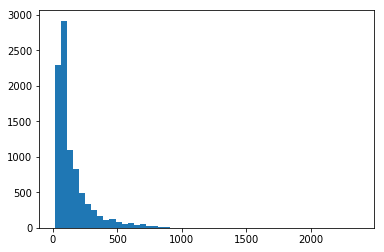

In [74]:
# 뉴스 기사 길이 시각화

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(line) for line in xtrain], bins=50)

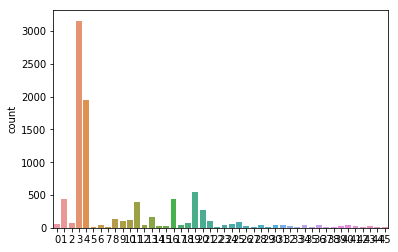

In [75]:
# 뉴스 카테고리 분포 시각화

import seaborn as sns

sns.countplot(ytrain)

In [0]:
import numpy as np

In [76]:
np.unique(ytrain, return_counts=True)    # return_counts: 갯수를 리턴
# 0번 카테고리는 55건, 1번 카테고리는 432건, 2번 카테고리는 74건, ... 의 뉴스 기사가 있다

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 array([  55,  432,   74, 3159, 1949,   17,   48,   16,  139,  101,  124,
         390,   49,  172,   26,   20,  444,   39,   66,  549,  269,  100,
          15,   41,   62,   92,   24,   15,   48,   19,   45,   39,   32,
          11,   50,   10,   49,   19,   19,   24,   36,   30,   13,   21,
          12,   18]))

In [0]:
unique_elements, counts_elements = np.unique(ytrain, return_counts=True)

In [78]:
np.asarray((unique_elements, counts_elements))

array([[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45],
       [  55,  432,   74, 3159, 1949,   17,   48,   16,  139,  101,  124,
         390,   49,  172,   26,   20,  444,   39,   66,  549,  269,  100,
          15,   41,   62,   92,   24,   15,   48,   19,   45,   39,   32,
          11,   50,   10,   49,   19,   19,   24,   36,   30,   13,   21,
          12,   18]])

In [79]:
dict(zip(unique_elements, counts_elements))

{0: 55,
 1: 432,
 2: 74,
 3: 3159,
 4: 1949,
 5: 17,
 6: 48,
 7: 16,
 8: 139,
 9: 101,
 10: 124,
 11: 390,
 12: 49,
 13: 172,
 14: 26,
 15: 20,
 16: 444,
 17: 39,
 18: 66,
 19: 549,
 20: 269,
 21: 100,
 22: 15,
 23: 41,
 24: 62,
 25: 92,
 26: 24,
 27: 15,
 28: 48,
 29: 19,
 30: 45,
 31: 39,
 32: 32,
 33: 11,
 34: 50,
 35: 10,
 36: 49,
 37: 19,
 38: 19,
 39: 24,
 40: 36,
 41: 30,
 42: 13,
 43: 21,
 44: 12,
 45: 18}

In [80]:
# 뉴스 기사 (xtrain) 의 단어들 출력

word_index = reuters.get_word_index()
word_index    # 인덱스 번호는 빈도 등수 => 숫자가 작을 수록 빈도가 높다

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [81]:
# 인덱스로 단어 찾기 쉽게 하는 함수 만들기

index_to_word = {}

for key, value in word_index.items():
  index_to_word[value] = key

index_to_word

{10996: 'mdbl',
 16260: 'fawc',
 12089: 'degussa',
 8803: 'woods',
 13796: 'hanging',
 20672: 'localized',
 20673: 'sation',
 20675: 'chanthaburi',
 10997: 'refunding',
 8804: 'hermann',
 20676: 'passsengers',
 20677: 'stipulate',
 8352: 'heublein',
 20713: 'screaming',
 16261: 'tcby',
 185: 'four',
 1642: 'grains',
 20680: 'broiler',
 12090: 'wooden',
 1220: 'wednesday',
 13797: 'highveld',
 7593: 'duffour',
 20681: '0053',
 3914: 'elections',
 2563: '270',
 3551: '271',
 5113: '272',
 3552: '273',
 3400: '274',
 7975: 'rudman',
 3401: '276',
 3478: '277',
 3632: '278',
 4309: '279',
 9381: 'dormancy',
 7247: 'errors',
 3086: 'deferred',
 20683: 'sptnd',
 8805: 'cooking',
 20684: 'stratabit',
 16262: 'designing',
 20685: 'metalurgicos',
 13798: 'databank',
 20686: '300er',
 20687: 'shocks',
 7972: 'nawg',
 20688: 'tnta',
 20689: 'perforations',
 2891: 'affiliates',
 20690: '27p',
 16263: 'ching',
 595: 'china',
 16264: 'wagyu',
 3189: 'affiliated',
 16265: 'chino',
 16266: 'chinh',
 2

In [82]:
index_to_word[1]

'the'

In [83]:
# 뉴스 기사 디코딩

print(" ".join(index_to_word[x] for x in xtrain[0]))
print(" ".join(index_to_word[x] for x in xtrain[1]))

the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs
the termination payment airport takes 6 visibility geological 3 6 602 begin up said fully bank expects commodity total is giant a recreation this takes leroy series termination payment airport mln a for capital 1 pre 50 american east said in council takes leroy recommend's france a but u any 4 s 1st losses pct dlrs


## LSTM 이용한 뉴스 분류

### 데이터 전처리

In [0]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(xtrain, ytrain), (xtest, ytest) = reuters.load_data(num_words=1000, test_split=0.2)
# 단어 등장 빈도수가 1000등 안에 있는 단어들 대상

# restore np.load for future normal usage
np.load = np_load_old

In [0]:
max_len = 100    # 각 뉴스 당 단어 길이를 최대 100개로 하겠다

# 단어 개수가 100개 넘으면 100개만 저장하고, 부족하면 0으로 채우자
from keras.preprocessing import sequence
xtrain = sequence.pad_sequences(xtrain, maxlen=max_len)
xtest = sequence.pad_sequences(xtest, maxlen=max_len)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import np_utils

In [87]:
# 레이블 원핫인코딩

ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
ytrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [88]:
len(ytrain[0])

46

### 모델 생성

In [0]:
model = Sequential()
model.add(Embedding(1000, 128))    # Embedding(단어 벡터 수 = 단어 종류 개수, 임베딩 벡터의 차원수
model.add(LSTM(128))
model.add(Dense(46, activation="softmax"))    # 원핫인코딩한 y의 길이가 46

In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [93]:
history = model.fit(xtrain, ytrain, batch_size=100, epochs=20, validation_data=(xtest, ytest))

W0828 02:57:06.908259 140191395362688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0828 02:57:07.496259 140191395362688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 29s 3ms/step - loss: 2.5858 - acc: 0.3437 - val_loss: 2.2794 - val_acc: 0.3678
Epoch 2/20
8982/8982 [==============================] - 28s 3ms/step - loss: 1.9900 - acc: 0.4809 - val_loss: 1.8532 - val_acc: 0.5205
Epoch 3/20
8982/8982 [==============================] - 28s 3ms/step - loss: 1.7912 - acc: 0.5358 - val_loss: 1.7827 - val_acc: 0.5263
Epoch 4/20
8982/8982 [==============================] - 28s 3ms/step - loss: 1.8517 - acc: 0.5150 - val_loss: 1.7327 - val_acc: 0.5565
Epoch 5/20
8982/8982 [==============================] - 28s 3ms/step - loss: 1.6544 - acc: 0.5703 - val_loss: 1.6743 - val_acc: 0.5619
Epoch 6/20
8982/8982 [==============================] - 28s 3ms/step - loss: 1.5808 - acc: 0.5902 - val_loss: 1.6544 - val_acc: 0.5726
Epoch 7/20
8982/8982 [==============================] - 28s 3ms/step - loss: 1.5141 - acc: 0.6165 - val_loss: 1.5527 - val_acc: 0.6033
Epoch 8

In [94]:
print("테스트 정확도: ", model.evaluate(xtest, ytest)[1])

2246/2246 [==============================] - 2s 711us/step
테스트 정확도:  0.7163846838293815


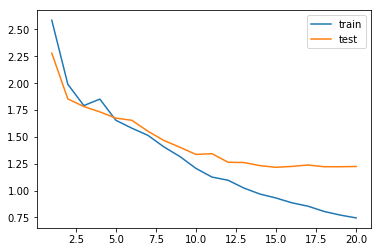

In [95]:
epochs = range(1, len(history.history["acc"])+1)
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="test")
plt.legend(loc="upper right")
plt.show()

# 네이버 영화 리뷰 분류

In [0]:
import pandas as pd

In [103]:
trainData = pd.read_table("/content/drive/My Drive/190000 멀티캠퍼스/Data/nsmc-master/ratings_train.txt")
trainData

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [106]:
len(trainData)

150000

In [101]:
type(trainData)

pandas.core.frame.DataFrame

In [105]:
testData = pd.read_table("/content/drive/My Drive/190000 멀티캠퍼스/Data/nsmc-master/ratings_test.txt")
testData

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


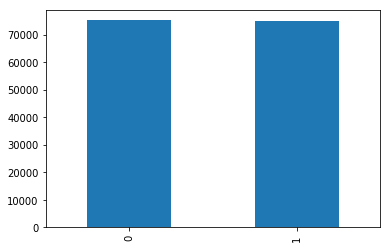

In [108]:
%matplotlib inline

trainData["label"].value_counts().plot(kind="bar")

In [110]:
# trainData.groupby("label").size()
trainData.groupby("label").size().reset_index(name="count")

,label,count
0,0,75173
1,1,74827


In [113]:
# 리뷰 중에 null이 있는지 확인

trainData["document"].isnull().values.any()    # any()를 하면 하나라도 true가 있으면 true가 나온다

True

In [114]:
# column별로 null이 몇 개 있는지 알고 싶다

trainData.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [119]:
# 리뷰가 null인 데이터 출력

trainData[trainData.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [121]:
# 리뷰 null값 제거

trainData = trainData.dropna(how="any")   # null값이 있는 행 제거
trainData[trainData.document.isnull()]

,id,document,label


In [122]:
len(trainData)

149995

## 영어 제거

영어 제거 (정규표현식) -> [a-zA-Z], sub, replace

In [0]:
import re

In [125]:
# 영어 제거 연습

sample_text  = "do!! you expec... to ~ read~, ~!! ??@"

# 공백, 영문자 제외하고 모두 제거
# re.sub(정규식, 바꾼 결과, 바꿀 대상)

re.sub("[^a-zA-Z ]","", sample_text)

'do you expec to  read  '

In [131]:
# trainData["document"].str.replace(바꾼 결과, 바꿀 표현)
trainData["document"] = trainData["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
trainData[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


## 형태소 분리

In [133]:
!pip install konlpy
import konlpy
from konlpy.tag import Okt

     |████████████████████████████████| 19.4MB 2.8MB/s 
     |████████████████████████████████| 2.7MB 29.5MB/s 


In [135]:
okt = Okt()
okt.morphs("포스터보고 초딩영화줄오버연기조차 가볍지 않구나")

['포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나']

In [137]:
okt.morphs("포스터보고 초딩영화줄오버연기조차 가볍지 않구나", stem=True)    # stem 옵션을 써서 단어를 기본형으로 변경

['포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다']

In [0]:
stopwords = ["의", "가", "이", "은", "하다", "한", "와", "에", "으로", "자", "과", "도", "걍", "잘", "좀", "는", "들", "을", "를", "것", "나"]

In [139]:
okt.morphs("에이 이런 것도 영화냐? 차라리 집에서 티브이나 보겠다", stem=True)

['에이', '이렇다', '것', '도', '영화', '냐', '?', '차라리', '집', '에서', '티브이', '나', '보다']

In [0]:
xtrain = []

for sentence in trainData["document"]:
  tempx = []
  tempx = okt.morphs(sentence, stem=True)
  tempx = [word for word in tempx if not word in stopwords]
  xtrain.append(tempx)

In [0]:
xtrain[:10]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '세',
  '부터',
  '초등학교',
  '학년',
  '생인',
  '살다',
  '영화',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '아깝다',
  '움'],
 ['원작', '긴장감', '제대로', '살리다'],
 ['별',
  '반개',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '드라마',
  '가족',
  '없다',
  '연기',
  '못',
  '사람',
  '만',
  '모',
  '엿',
  '네'],
 ['액션', '없다', '재미', '있다', '몇', '안되다', '영화'],
 ['왜케',
  '평점',
  '낮다',
  '꽤',
  '볼',
  '만',
  '데',
  '헐리우드',
  '식',
  '화려하다',
  '너무',
  '길들이다',
  '있다']]

In [148]:
testData = testData.dropna(how="any") 
testData["document"] = testData["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

xtest = []

for sentence in testData["document"]:
  tempx = []
  tempx = okt.morphs(sentence, stem=True)
  tempx = [word for word in tempx if not word in stopwords]
  xtest.append(tempx)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 토큰화

In [0]:
from keras.preprocessing.text import Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(xtrain)

In [0]:
xtrain = tokenizer.texts_to_sequences(xtrain)
xtest = tokenizer.texts_to_sequences(xtest)

## 패딩

In [152]:
# 리뷰 단어 최대 길이
print(max(len(line) for line in xtrain))

# 리뷰 평균 길이
print(sum(map(len, xtrain)) / len(xtrain))

69
10.379005966865563


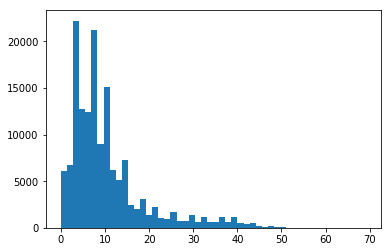

In [153]:
# 시각화 확인

plt.hist([len(line) for line in xtrain], bins=50)
plt.show()

In [0]:
ytrain = trainData["label"]
ytest = testData["label"]

In [0]:
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [0]:
maxLen = 30    # 데이터(리뷰) 최대 길이를 30으로 설정
xtrain = pad_sequences(xtrain, maxlen=maxLen)
xtest = pad_sequences(xtest, maxlen=maxLen)

## LSTM 기반 영화 리뷰 감성 분류기 제작

In [0]:
model = Sequential()
model.add(Embedding(30000, 100))    # 30000: 단어 종류 개수, 100: 차원
model.add(LSTM(128))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [160]:
history = model.fit(xtrain, ytrain, epochs=4, batch_size=60, validation_split=0.2)

Train on 119996 samples, validate on 29999 samples
Epoch 1/4
119996/119996 [==============================] - 186s 2ms/step - loss: 0.3911 - acc: 0.8211 - val_loss: 0.3538 - val_acc: 0.8416
Epoch 2/4
119996/119996 [==============================] - 185s 2ms/step - loss: 0.3298 - acc: 0.8555 - val_loss: 0.3327 - val_acc: 0.8539
Epoch 3/4
119996/119996 [==============================] - 186s 2ms/step - loss: 0.3032 - acc: 0.8699 - val_loss: 0.3315 - val_acc: 0.8563
Epoch 4/4
119996/119996 [==============================] - 185s 2ms/step - loss: 0.2831 - acc: 0.8817 - val_loss: 0.3314 - val_acc: 0.8572


In [161]:
model.evaluate(xtest, ytest)    # loss value, metrics values (accuracy in this case)

49997/49997 [==============================] - 13s 264us/step


[0.34085518238134216, 0.8523511410696563]

In [162]:
history.history

{'acc': [0.8211190386761696,
  0.8554535163530147,
  0.8698706618825326,
  0.881737723559625],
 'loss': [0.39106236336179495,
  0.32977122520869157,
  0.3032409913335972,
  0.28311501278548906],
 'val_acc': [0.8415613870564459,
  0.853895130602613,
  0.8562618779152201,
  0.8572285748540595],
 'val_loss': [0.35381080026074074,
  0.33267880340644396,
  0.33150989989478724,
  0.3314006487404634]}

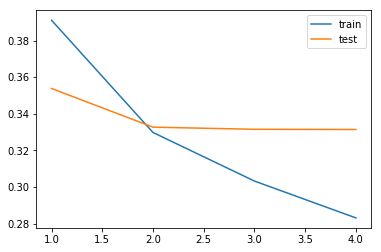

In [163]:
epochs = range(1, len(history.history["acc"])+1)
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="test")
plt.legend(loc="upper right")
plt.show()